# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

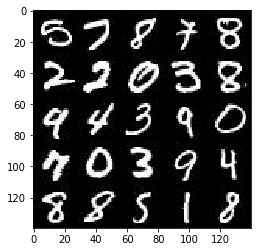

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

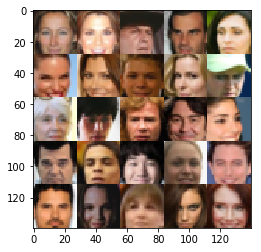

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [29]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [30]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 256, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 512, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        flat = tf.reshape(relu2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if data_image_mode == 'RGB':
        data_depth = 3
    else:
        data_depth = 1   
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_depth)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                d_feed_dict = {input_real: batch_images,
                               input_z: batch_z,
                               learn_rate:learning_rate
                              }
                
                g_feed_dict = {input_z: batch_z}
                
                _ = sess.run(d_train_opt, feed_dict=d_feed_dict)
                _ = sess.run(g_train_opt, feed_dict=g_feed_dict)
                
                if step % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict=d_feed_dict)
                    train_loss_g = sess.run(g_loss, feed_dict=g_feed_dict)

                    print("Iteration {}...".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % 50 == 0:
                    show_generator_output(sess, 25, input_z, data_depth, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Iteration 10... Discriminator Loss: 0.6743... Generator Loss: 1.1090
Iteration 20... Discriminator Loss: 1.2298... Generator Loss: 0.5810
Iteration 30... Discriminator Loss: 0.8608... Generator Loss: 0.9726
Iteration 40... Discriminator Loss: 0.9314... Generator Loss: 0.7370
Iteration 50... Discriminator Loss: 0.5963... Generator Loss: 1.6699


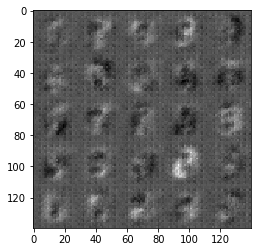

Iteration 60... Discriminator Loss: 0.7455... Generator Loss: 0.9476
Iteration 70... Discriminator Loss: 0.6148... Generator Loss: 1.3619
Iteration 80... Discriminator Loss: 0.5167... Generator Loss: 1.4695
Iteration 90... Discriminator Loss: 0.4654... Generator Loss: 1.5103
Iteration 100... Discriminator Loss: 0.4932... Generator Loss: 1.3087


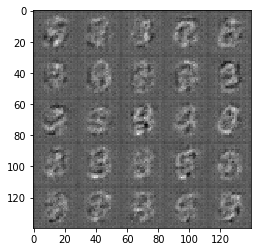

Iteration 110... Discriminator Loss: 0.4248... Generator Loss: 1.6950
Iteration 120... Discriminator Loss: 0.2531... Generator Loss: 2.3137
Iteration 130... Discriminator Loss: 0.2628... Generator Loss: 2.0250
Iteration 140... Discriminator Loss: 0.2781... Generator Loss: 1.8011
Iteration 150... Discriminator Loss: 0.2780... Generator Loss: 2.8584


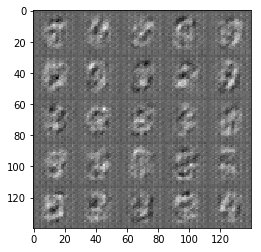

Iteration 160... Discriminator Loss: 0.2623... Generator Loss: 2.0830
Iteration 170... Discriminator Loss: 0.4491... Generator Loss: 2.6286
Iteration 180... Discriminator Loss: 0.2461... Generator Loss: 2.1228
Iteration 190... Discriminator Loss: 0.5084... Generator Loss: 3.8871
Iteration 200... Discriminator Loss: 0.2230... Generator Loss: 2.2285


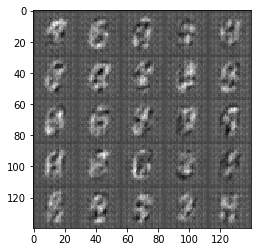

Iteration 210... Discriminator Loss: 0.2601... Generator Loss: 1.8749
Iteration 220... Discriminator Loss: 0.2326... Generator Loss: 3.0473
Iteration 230... Discriminator Loss: 0.2068... Generator Loss: 2.6774
Iteration 240... Discriminator Loss: 0.1869... Generator Loss: 2.4740
Iteration 250... Discriminator Loss: 0.1896... Generator Loss: 2.3211


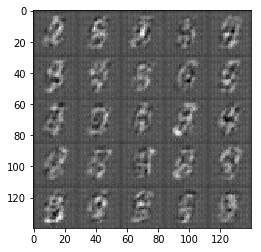

Iteration 260... Discriminator Loss: 0.1961... Generator Loss: 2.2179
Iteration 270... Discriminator Loss: 0.6605... Generator Loss: 4.5594
Iteration 280... Discriminator Loss: 0.2484... Generator Loss: 2.2695
Iteration 290... Discriminator Loss: 0.1882... Generator Loss: 2.7285
Iteration 300... Discriminator Loss: 0.2089... Generator Loss: 2.1502


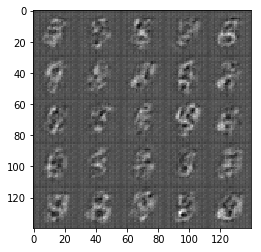

Iteration 310... Discriminator Loss: 0.1639... Generator Loss: 2.7809
Iteration 320... Discriminator Loss: 0.2128... Generator Loss: 2.2346
Iteration 330... Discriminator Loss: 0.1487... Generator Loss: 2.6668
Iteration 340... Discriminator Loss: 0.1413... Generator Loss: 3.2009
Iteration 350... Discriminator Loss: 0.1484... Generator Loss: 2.6980


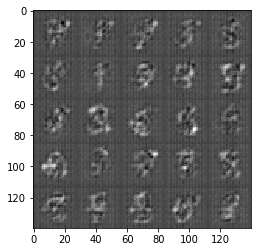

Iteration 360... Discriminator Loss: 0.1640... Generator Loss: 2.5262
Iteration 370... Discriminator Loss: 1.7907... Generator Loss: 0.2444
Iteration 380... Discriminator Loss: 0.3014... Generator Loss: 1.9866
Iteration 390... Discriminator Loss: 0.2846... Generator Loss: 2.6468
Iteration 400... Discriminator Loss: 0.2125... Generator Loss: 2.4440


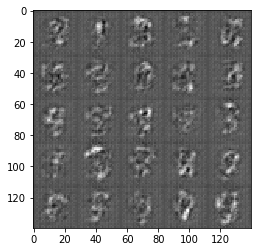

Iteration 410... Discriminator Loss: 0.2149... Generator Loss: 2.5553
Iteration 420... Discriminator Loss: 0.1549... Generator Loss: 2.8625
Iteration 430... Discriminator Loss: 0.1689... Generator Loss: 2.7267
Iteration 440... Discriminator Loss: 0.1947... Generator Loss: 2.6040
Iteration 450... Discriminator Loss: 0.1375... Generator Loss: 2.8823


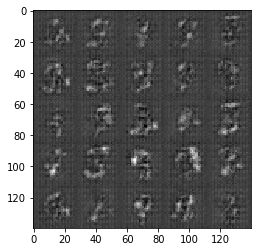

Iteration 460... Discriminator Loss: 0.1469... Generator Loss: 2.9893
Iteration 470... Discriminator Loss: 0.1357... Generator Loss: 3.0324
Iteration 480... Discriminator Loss: 0.1505... Generator Loss: 2.9648
Iteration 490... Discriminator Loss: 0.1305... Generator Loss: 3.1068
Iteration 500... Discriminator Loss: 0.1135... Generator Loss: 3.4554


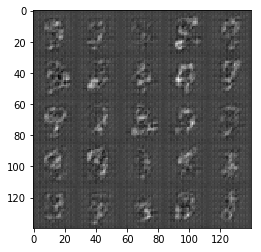

Iteration 510... Discriminator Loss: 0.1204... Generator Loss: 3.5306
Iteration 520... Discriminator Loss: 0.1003... Generator Loss: 3.4642
Iteration 530... Discriminator Loss: 0.1149... Generator Loss: 3.4123
Iteration 540... Discriminator Loss: 0.1240... Generator Loss: 3.1497
Iteration 550... Discriminator Loss: 0.1522... Generator Loss: 2.7898


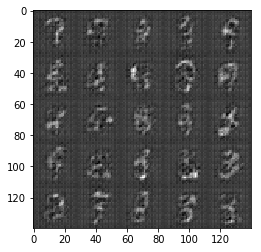

Iteration 560... Discriminator Loss: 0.0859... Generator Loss: 3.6843
Iteration 570... Discriminator Loss: 0.0854... Generator Loss: 3.7721
Iteration 580... Discriminator Loss: 0.0916... Generator Loss: 3.6308
Iteration 590... Discriminator Loss: 0.1152... Generator Loss: 3.3745
Iteration 600... Discriminator Loss: 0.1014... Generator Loss: 3.4509


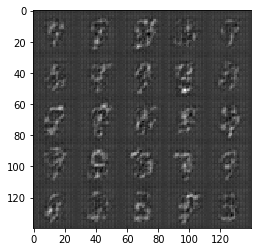

Iteration 610... Discriminator Loss: 0.0884... Generator Loss: 3.6572
Iteration 620... Discriminator Loss: 0.0709... Generator Loss: 3.9211
Iteration 630... Discriminator Loss: 0.0986... Generator Loss: 3.1732
Iteration 640... Discriminator Loss: 0.0914... Generator Loss: 3.9492
Iteration 650... Discriminator Loss: 0.0849... Generator Loss: 3.4556


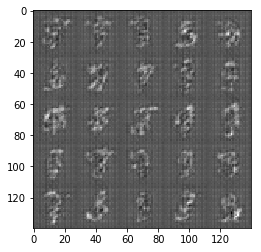

Iteration 660... Discriminator Loss: 0.0664... Generator Loss: 3.9805
Iteration 670... Discriminator Loss: 0.0655... Generator Loss: 3.6452
Iteration 680... Discriminator Loss: 0.0740... Generator Loss: 3.6680
Iteration 690... Discriminator Loss: 0.0711... Generator Loss: 4.0184
Iteration 700... Discriminator Loss: 0.0511... Generator Loss: 4.2626


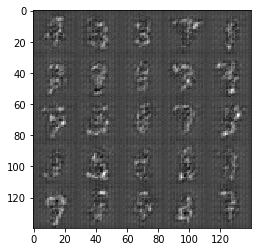

Iteration 710... Discriminator Loss: 0.0881... Generator Loss: 3.5379
Iteration 720... Discriminator Loss: 0.0784... Generator Loss: 3.4613
Iteration 730... Discriminator Loss: 0.0533... Generator Loss: 4.0752
Iteration 740... Discriminator Loss: 0.0695... Generator Loss: 3.7077
Iteration 750... Discriminator Loss: 0.0597... Generator Loss: 4.3924


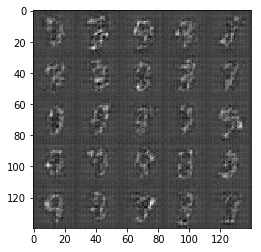

Iteration 760... Discriminator Loss: 0.0588... Generator Loss: 3.9922
Iteration 770... Discriminator Loss: 0.0573... Generator Loss: 4.0424
Iteration 780... Discriminator Loss: 0.0416... Generator Loss: 4.2641
Iteration 790... Discriminator Loss: 0.0750... Generator Loss: 3.8886
Iteration 800... Discriminator Loss: 0.1230... Generator Loss: 2.7688


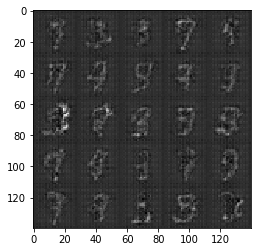

Iteration 810... Discriminator Loss: 0.0629... Generator Loss: 3.7404
Iteration 820... Discriminator Loss: 0.0619... Generator Loss: 4.9114
Iteration 830... Discriminator Loss: 0.0854... Generator Loss: 3.2041
Iteration 840... Discriminator Loss: 2.1157... Generator Loss: 0.2148
Iteration 850... Discriminator Loss: 0.3555... Generator Loss: 5.4049


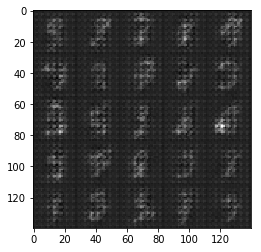

Iteration 860... Discriminator Loss: 0.1850... Generator Loss: 3.2480
Iteration 870... Discriminator Loss: 0.1708... Generator Loss: 3.2696
Iteration 880... Discriminator Loss: 0.3077... Generator Loss: 1.9451
Iteration 890... Discriminator Loss: 0.2520... Generator Loss: 2.2048
Iteration 900... Discriminator Loss: 0.2230... Generator Loss: 2.5696


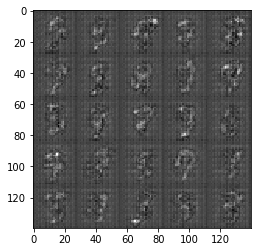

Iteration 910... Discriminator Loss: 0.1532... Generator Loss: 2.8462
Iteration 920... Discriminator Loss: 0.1544... Generator Loss: 2.8322
Iteration 930... Discriminator Loss: 0.0731... Generator Loss: 3.9775


In [36]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Iteration 10... Discriminator Loss: 0.7487... Generator Loss: 1.0677
Iteration 20... Discriminator Loss: 0.6844... Generator Loss: 1.4323
Iteration 30... Discriminator Loss: 0.9812... Generator Loss: 0.7177
Iteration 40... Discriminator Loss: 0.6366... Generator Loss: 1.1834
Iteration 50... Discriminator Loss: 0.7308... Generator Loss: 4.0333


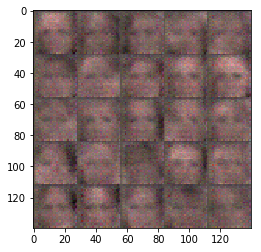

Iteration 60... Discriminator Loss: 0.5549... Generator Loss: 1.4196
Iteration 70... Discriminator Loss: 0.5289... Generator Loss: 1.3331
Iteration 80... Discriminator Loss: 0.9025... Generator Loss: 0.9574
Iteration 90... Discriminator Loss: 0.7920... Generator Loss: 1.3522
Iteration 100... Discriminator Loss: 0.7355... Generator Loss: 2.5823


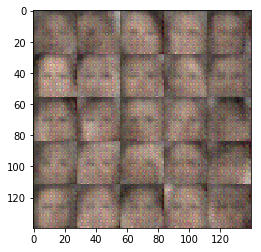

Iteration 110... Discriminator Loss: 0.9933... Generator Loss: 0.5622
Iteration 120... Discriminator Loss: 0.4927... Generator Loss: 1.9574
Iteration 130... Discriminator Loss: 0.9029... Generator Loss: 0.7090
Iteration 140... Discriminator Loss: 0.7708... Generator Loss: 0.8772
Iteration 150... Discriminator Loss: 0.5245... Generator Loss: 1.4324


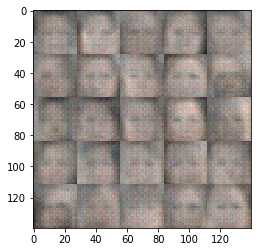

Iteration 160... Discriminator Loss: 0.5986... Generator Loss: 1.3320
Iteration 170... Discriminator Loss: 0.5862... Generator Loss: 1.1315
Iteration 180... Discriminator Loss: 0.4348... Generator Loss: 1.5817
Iteration 190... Discriminator Loss: 0.5236... Generator Loss: 1.3558
Iteration 200... Discriminator Loss: 0.2838... Generator Loss: 2.1144


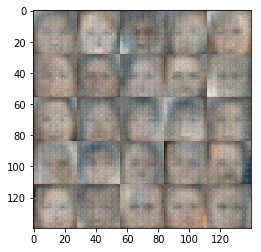

Iteration 210... Discriminator Loss: 0.6191... Generator Loss: 1.0655
Iteration 220... Discriminator Loss: 0.5125... Generator Loss: 1.6141
Iteration 230... Discriminator Loss: 0.5029... Generator Loss: 1.8915
Iteration 240... Discriminator Loss: 0.6979... Generator Loss: 0.8769
Iteration 250... Discriminator Loss: 0.2540... Generator Loss: 6.4578


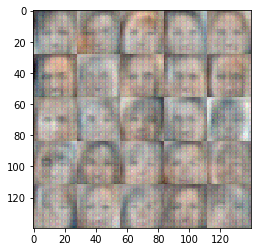

Iteration 260... Discriminator Loss: 0.4336... Generator Loss: 17.3171
Iteration 270... Discriminator Loss: 0.4167... Generator Loss: 10.1014
Iteration 280... Discriminator Loss: 0.1593... Generator Loss: 6.1662
Iteration 290... Discriminator Loss: 0.5149... Generator Loss: 1.6536
Iteration 300... Discriminator Loss: 0.4735... Generator Loss: 3.9147


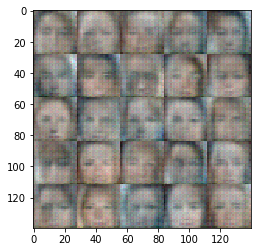

Iteration 310... Discriminator Loss: 0.3829... Generator Loss: 9.3455
Iteration 320... Discriminator Loss: 1.0594... Generator Loss: 0.5493
Iteration 330... Discriminator Loss: 0.5022... Generator Loss: 3.5668
Iteration 340... Discriminator Loss: 0.6089... Generator Loss: 1.1252
Iteration 350... Discriminator Loss: 0.4833... Generator Loss: 1.5223


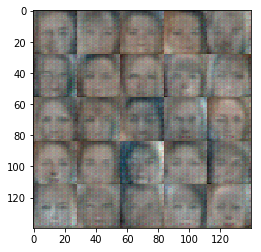

Iteration 360... Discriminator Loss: 0.6410... Generator Loss: 2.4169
Iteration 370... Discriminator Loss: 0.1652... Generator Loss: 3.7112
Iteration 380... Discriminator Loss: 1.2500... Generator Loss: 0.7888
Iteration 390... Discriminator Loss: 0.2084... Generator Loss: 12.7567
Iteration 400... Discriminator Loss: 0.4886... Generator Loss: 7.4677


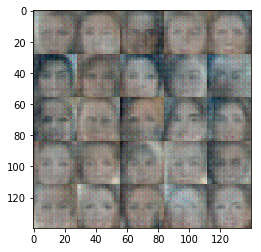

Iteration 410... Discriminator Loss: 0.2520... Generator Loss: 4.6427
Iteration 420... Discriminator Loss: 0.2901... Generator Loss: 15.5810
Iteration 430... Discriminator Loss: 0.0521... Generator Loss: 12.6185
Iteration 440... Discriminator Loss: 0.1836... Generator Loss: 5.6054
Iteration 450... Discriminator Loss: 0.0365... Generator Loss: 11.4636


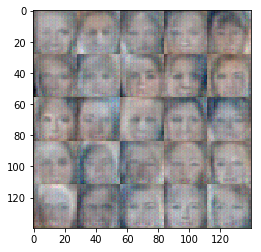

Iteration 460... Discriminator Loss: 0.1533... Generator Loss: 5.2754
Iteration 470... Discriminator Loss: 0.1982... Generator Loss: 16.1196
Iteration 480... Discriminator Loss: 0.2673... Generator Loss: 3.7353
Iteration 490... Discriminator Loss: 0.1046... Generator Loss: 4.3363
Iteration 500... Discriminator Loss: 0.2767... Generator Loss: 2.3187


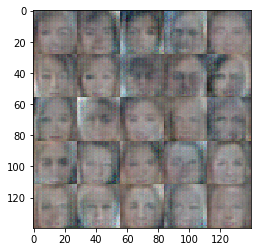

Iteration 510... Discriminator Loss: 0.1056... Generator Loss: 3.0099
Iteration 520... Discriminator Loss: 1.3582... Generator Loss: 0.3713
Iteration 530... Discriminator Loss: 0.1152... Generator Loss: 17.7345
Iteration 540... Discriminator Loss: 0.2974... Generator Loss: 12.2807
Iteration 550... Discriminator Loss: 0.3010... Generator Loss: 8.7424


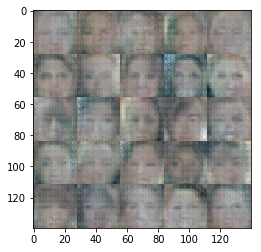

Iteration 560... Discriminator Loss: 0.1747... Generator Loss: 3.7520
Iteration 570... Discriminator Loss: 2.1445... Generator Loss: 0.1407
Iteration 580... Discriminator Loss: 0.0921... Generator Loss: 8.3381
Iteration 590... Discriminator Loss: 0.1371... Generator Loss: 11.2138
Iteration 600... Discriminator Loss: 0.0276... Generator Loss: 10.7527


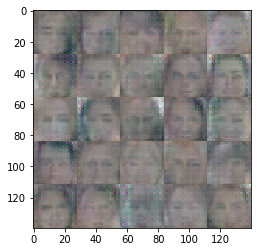

Iteration 610... Discriminator Loss: 0.0233... Generator Loss: 6.2317
Iteration 620... Discriminator Loss: 1.1902... Generator Loss: 0.4486
Iteration 630... Discriminator Loss: 0.3676... Generator Loss: 4.6218
Iteration 640... Discriminator Loss: 0.2392... Generator Loss: 6.5963
Iteration 650... Discriminator Loss: 1.5852... Generator Loss: 0.2734


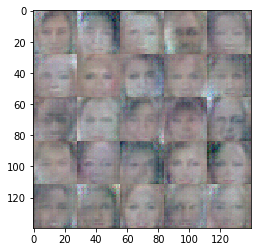

Iteration 660... Discriminator Loss: 0.3675... Generator Loss: 12.3941
Iteration 670... Discriminator Loss: 1.9526... Generator Loss: 0.1914
Iteration 680... Discriminator Loss: 0.3131... Generator Loss: 6.3641
Iteration 690... Discriminator Loss: 0.0728... Generator Loss: 13.1095
Iteration 700... Discriminator Loss: 0.0428... Generator Loss: 14.1129


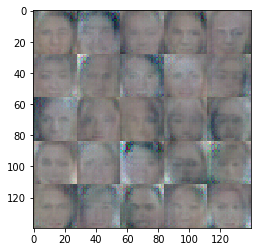

Iteration 710... Discriminator Loss: 0.0781... Generator Loss: 4.0929
Iteration 720... Discriminator Loss: 0.9269... Generator Loss: 0.7104
Iteration 730... Discriminator Loss: 0.1534... Generator Loss: 7.8840
Iteration 740... Discriminator Loss: 0.0324... Generator Loss: 15.2554
Iteration 750... Discriminator Loss: 0.0442... Generator Loss: 9.4762


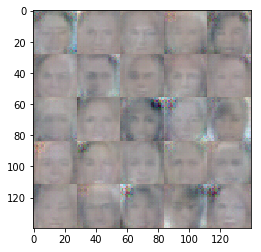

Iteration 760... Discriminator Loss: 0.4348... Generator Loss: 7.6539
Iteration 770... Discriminator Loss: 0.0794... Generator Loss: 10.0745
Iteration 780... Discriminator Loss: 0.2709... Generator Loss: 3.5766
Iteration 790... Discriminator Loss: 0.0758... Generator Loss: 6.0127
Iteration 800... Discriminator Loss: 0.1405... Generator Loss: 3.4668


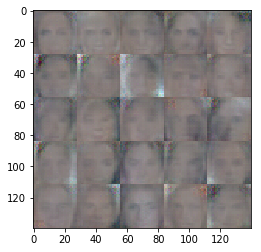

Iteration 810... Discriminator Loss: 0.0424... Generator Loss: 8.1178
Iteration 820... Discriminator Loss: 0.1731... Generator Loss: 10.4490
Iteration 830... Discriminator Loss: 0.6790... Generator Loss: 1.1205
Iteration 840... Discriminator Loss: 0.4899... Generator Loss: 1.9320
Iteration 850... Discriminator Loss: 0.0311... Generator Loss: 8.0135


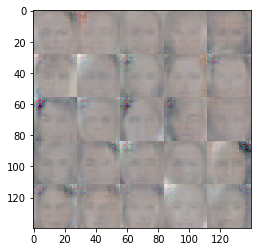

Iteration 860... Discriminator Loss: 0.0426... Generator Loss: 11.9323
Iteration 870... Discriminator Loss: 0.4443... Generator Loss: 1.5553
Iteration 880... Discriminator Loss: 0.2876... Generator Loss: 5.7449
Iteration 890... Discriminator Loss: 0.0763... Generator Loss: 11.4202
Iteration 900... Discriminator Loss: 0.0571... Generator Loss: 8.1687


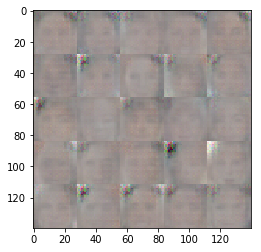

Iteration 910... Discriminator Loss: 0.0652... Generator Loss: 9.5922
Iteration 920... Discriminator Loss: 0.0627... Generator Loss: 6.3084
Iteration 930... Discriminator Loss: 0.0949... Generator Loss: 7.2014
Iteration 940... Discriminator Loss: 0.0829... Generator Loss: 11.4415
Iteration 950... Discriminator Loss: 0.3219... Generator Loss: 2.8706


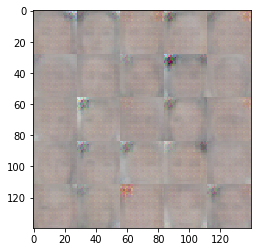

Iteration 960... Discriminator Loss: 0.1190... Generator Loss: 8.8027
Iteration 970... Discriminator Loss: 0.0991... Generator Loss: 5.1281
Iteration 980... Discriminator Loss: 0.1462... Generator Loss: 3.8811
Iteration 990... Discriminator Loss: 0.0867... Generator Loss: 8.0978
Iteration 1000... Discriminator Loss: 0.3763... Generator Loss: 1.5073


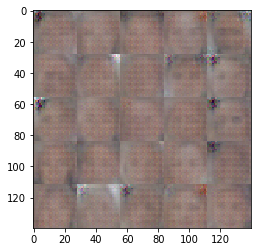

Iteration 1010... Discriminator Loss: 0.1427... Generator Loss: 2.8523
Iteration 1020... Discriminator Loss: 1.1154... Generator Loss: 0.6149
Iteration 1030... Discriminator Loss: 0.1478... Generator Loss: 7.8430
Iteration 1040... Discriminator Loss: 0.6695... Generator Loss: 1.0387
Iteration 1050... Discriminator Loss: 0.1066... Generator Loss: 13.7102


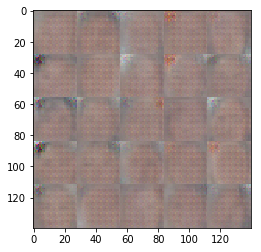

Iteration 1060... Discriminator Loss: 0.2579... Generator Loss: 2.2399
Iteration 1070... Discriminator Loss: 0.1024... Generator Loss: 5.2481
Iteration 1080... Discriminator Loss: 0.2200... Generator Loss: 4.8152
Iteration 1090... Discriminator Loss: 0.0593... Generator Loss: 7.3839
Iteration 1100... Discriminator Loss: 0.0785... Generator Loss: 8.6462


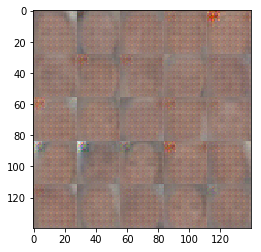

Iteration 1110... Discriminator Loss: 0.0788... Generator Loss: 8.7893
Iteration 1120... Discriminator Loss: 0.1135... Generator Loss: 6.3647
Iteration 1130... Discriminator Loss: 0.1197... Generator Loss: 5.4632
Iteration 1140... Discriminator Loss: 0.1112... Generator Loss: 4.2232
Iteration 1150... Discriminator Loss: 0.4385... Generator Loss: 1.5114


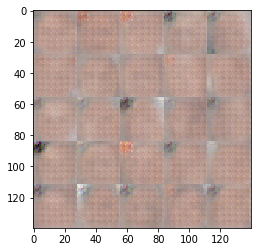

Iteration 1160... Discriminator Loss: 0.1507... Generator Loss: 7.1141
Iteration 1170... Discriminator Loss: 0.6838... Generator Loss: 9.4061
Iteration 1180... Discriminator Loss: 0.2126... Generator Loss: 6.4713
Iteration 1190... Discriminator Loss: 0.0634... Generator Loss: 6.3488
Iteration 1200... Discriminator Loss: 0.1752... Generator Loss: 9.1034


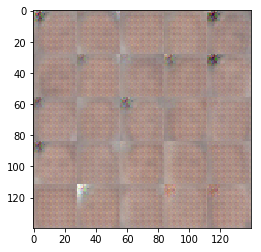

Iteration 1210... Discriminator Loss: 0.0922... Generator Loss: 5.5754
Iteration 1220... Discriminator Loss: 0.0865... Generator Loss: 5.8163
Iteration 1230... Discriminator Loss: 0.0752... Generator Loss: 7.2350
Iteration 1240... Discriminator Loss: 0.1848... Generator Loss: 4.5600
Iteration 1250... Discriminator Loss: 0.4282... Generator Loss: 3.7113


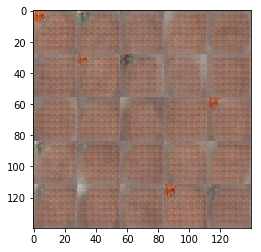

Iteration 1260... Discriminator Loss: 0.1807... Generator Loss: 5.0186
Iteration 1270... Discriminator Loss: 0.1647... Generator Loss: 5.7437
Iteration 1280... Discriminator Loss: 0.1763... Generator Loss: 3.1150
Iteration 1290... Discriminator Loss: 0.2003... Generator Loss: 3.3875
Iteration 1300... Discriminator Loss: 0.1209... Generator Loss: 8.5343


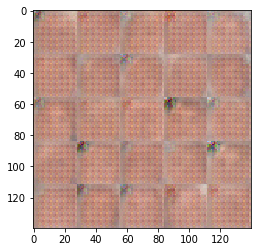

Iteration 1310... Discriminator Loss: 0.4245... Generator Loss: 3.4847
Iteration 1320... Discriminator Loss: 0.3707... Generator Loss: 5.3671
Iteration 1330... Discriminator Loss: 0.2768... Generator Loss: 5.3087
Iteration 1340... Discriminator Loss: 0.1770... Generator Loss: 5.8049
Iteration 1350... Discriminator Loss: 0.2148... Generator Loss: 3.1277


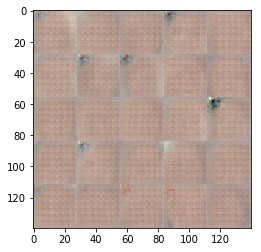

Iteration 1360... Discriminator Loss: 0.1991... Generator Loss: 3.4883
Iteration 1370... Discriminator Loss: 0.1079... Generator Loss: 5.2386
Iteration 1380... Discriminator Loss: 0.4347... Generator Loss: 1.5760
Iteration 1390... Discriminator Loss: 0.3692... Generator Loss: 2.2725
Iteration 1400... Discriminator Loss: 0.1327... Generator Loss: 4.7689


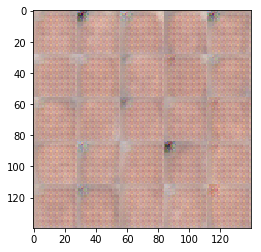

Iteration 1410... Discriminator Loss: 0.0848... Generator Loss: 7.5910
Iteration 1420... Discriminator Loss: 0.1442... Generator Loss: 3.2677
Iteration 1430... Discriminator Loss: 0.6098... Generator Loss: 1.2413
Iteration 1440... Discriminator Loss: 0.1148... Generator Loss: 6.4199
Iteration 1450... Discriminator Loss: 0.2692... Generator Loss: 2.8138


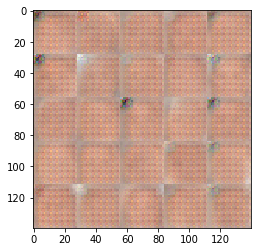

Iteration 1460... Discriminator Loss: 0.3541... Generator Loss: 3.0240
Iteration 1470... Discriminator Loss: 0.0922... Generator Loss: 5.0108
Iteration 1480... Discriminator Loss: 0.6497... Generator Loss: 2.7495
Iteration 1490... Discriminator Loss: 0.1501... Generator Loss: 4.9450
Iteration 1500... Discriminator Loss: 0.5202... Generator Loss: 1.4565


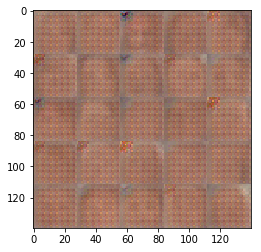

Iteration 1510... Discriminator Loss: 0.0709... Generator Loss: 8.6586
Iteration 1520... Discriminator Loss: 0.0731... Generator Loss: 8.6508
Iteration 1530... Discriminator Loss: 0.1125... Generator Loss: 4.5283
Iteration 1540... Discriminator Loss: 0.0839... Generator Loss: 9.2518
Iteration 1550... Discriminator Loss: 0.0826... Generator Loss: 8.5811


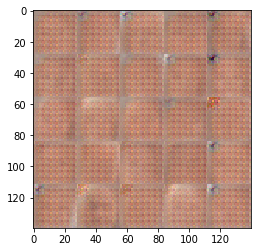

Iteration 1560... Discriminator Loss: 0.1012... Generator Loss: 10.0867
Iteration 1570... Discriminator Loss: 0.0752... Generator Loss: 6.8249
Iteration 1580... Discriminator Loss: 0.5801... Generator Loss: 2.0674


In [38]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.